In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [5]:
dataset_path = "../data/chest_xray"

In [6]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [7]:
len(dataset)

5856

In [8]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [9]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

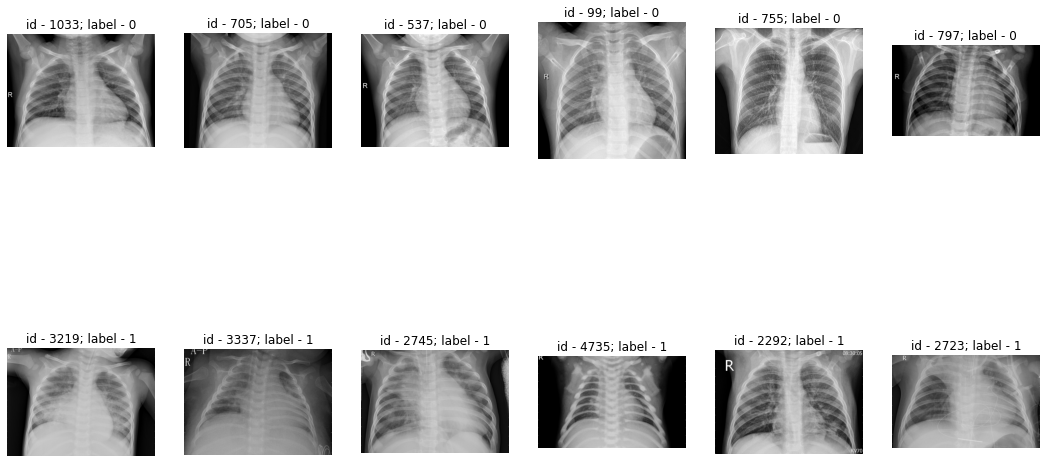

In [10]:
visualize_classes(dataset)

In [11]:
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [12]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

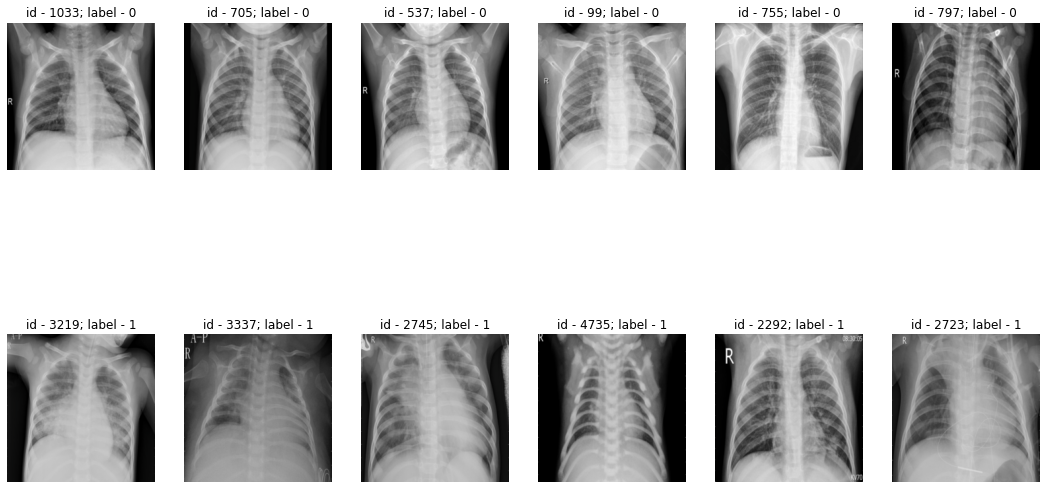

In [13]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=2
)

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [17]:
device = "cuda:0"
# device = "cpu"

### Load model

In [19]:
save_path = "../models/5.1_resnext50_2021-04-13_02:31:08.pt"

In [20]:
model = models.resnext50_32x4d()
model.fc = nn.Sequential(
    nn.Linear(2048, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Analyze results

In [21]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:06<00:00,  5.89it/s]


In [22]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [23]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [24]:
df["error_type"] = df.apply(error_class, axis=1)

In [25]:
df.groupby("error_type").count()

true  pred  prob
error_type                  
FN            14    14    14
FP            24    24    24
TN           283   283   283
TP           851   851   851

In [26]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9675767918088737
average_precision_score - 0.9687757806004683


In [27]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [28]:
df

true  pred      prob error_type
0        1     1  0.999646         TP
1        1     1  0.999826         TP
2        1     1  0.998721         TP
3        0     0  0.002491         TN
4        0     0  0.004422         TN
...    ...   ...       ...        ...
1167     1     1  0.999890         TP
1168     1     1  0.999834         TP
1169     1     1  0.999870         TP
1170     1     1  0.969020         TP
1171     0     0  0.002825         TN

[1172 rows x 4 columns]

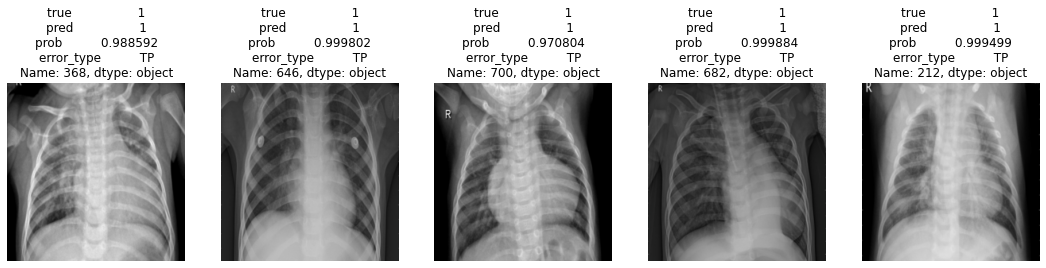

In [29]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

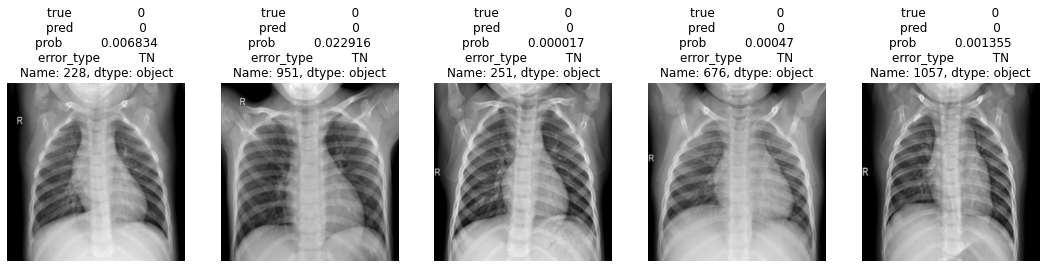

In [30]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

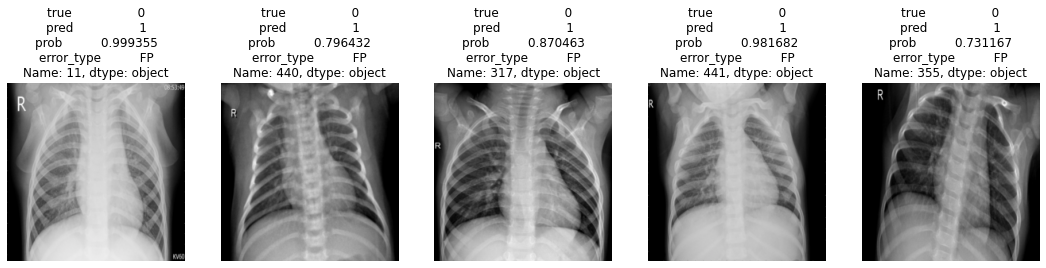

In [31]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

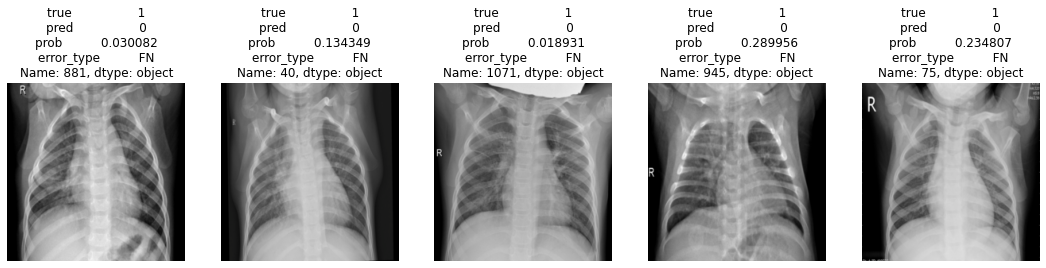

In [32]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [34]:
original_image_id = 0

In [35]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [36]:
image, label = dataset[original_image_id]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

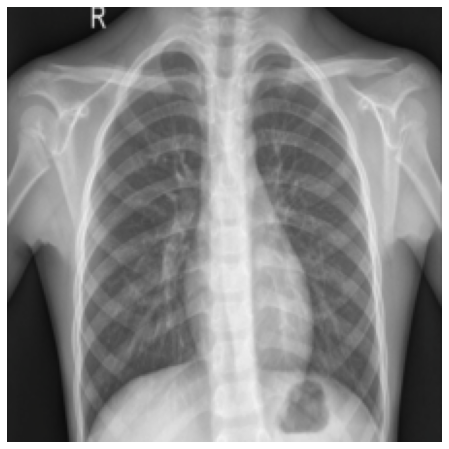

0.00041525377

In [37]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [38]:
from art.estimators.classification import PyTorchClassifier

In [39]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [40]:
image, label = dataset[original_image_id]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

0.00041525377


#### Loss gradient 

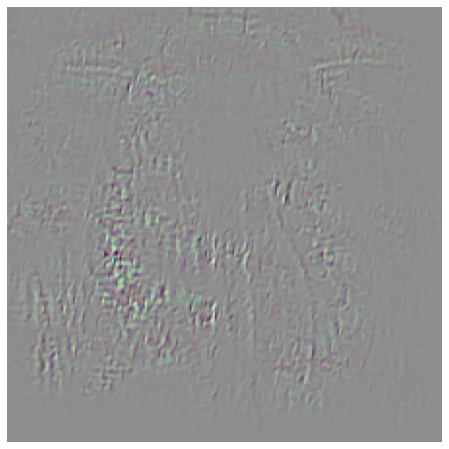

In [41]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [42]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

#### ProjectedGradientDescent

In [43]:
def pgd(eps, max_iter=50):
    # Create the attacker:
    adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=max_iter, eps_step=1, eps=eps)

    # Generate the adversarial sample:
    x_art_adv = adv.generate(image.cpu(), y=to_categorical([1], nb_classes=2))

    # Plot the adversarial sample (note: we swap color channels back to RGB order):
    img_to_show = inv_normalize(torch.tensor(x_art_adv[0])).numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

    # And apply the classifier to it:
    pred_adv = art_classifier.predict(x_art_adv)
    print(pred_adv[0][1])
    return x_art_adv, pred_adv[0][1]

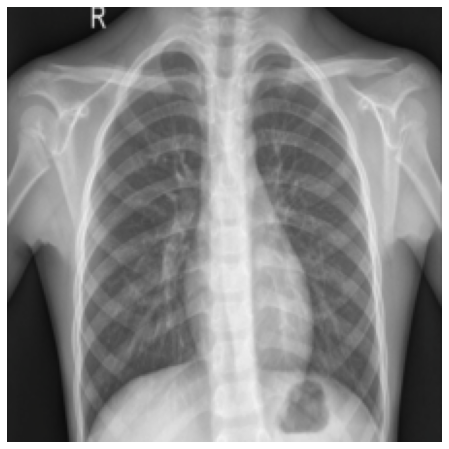

0.00041525377


In [44]:
_, _ = pgd(0)

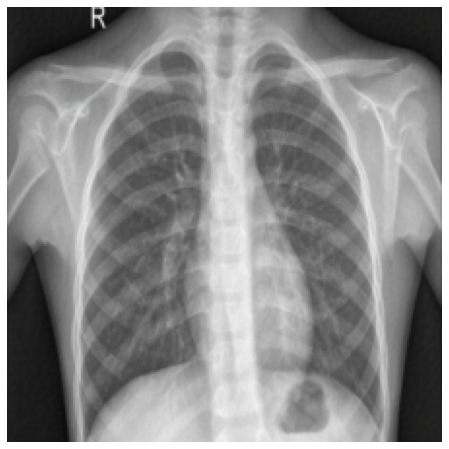

0.54410666


In [45]:
image_pgd_1, _ = pgd(0.02, max_iter=50)

Perturbation l_0 norm: 100%
Perturbation l_1 norm: 1%
Perturbation l_2 norm: 1%
Noise l_inf norm: 1%


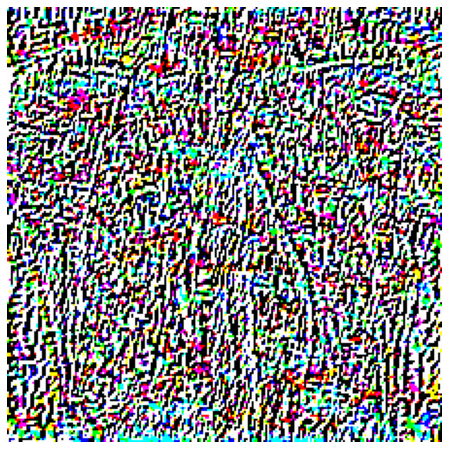

In [46]:
norms(image, image_pgd_1)

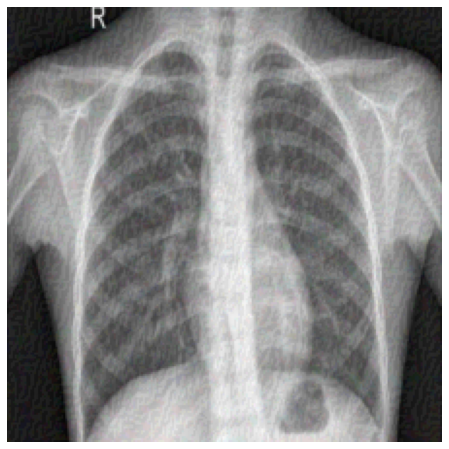

0.9997112


In [47]:
image_pgd_2, _ = pgd(0.1, max_iter=50)

Perturbation l_0 norm: 100%
Perturbation l_1 norm: 5%
Perturbation l_2 norm: 4%
Noise l_inf norm: 3%


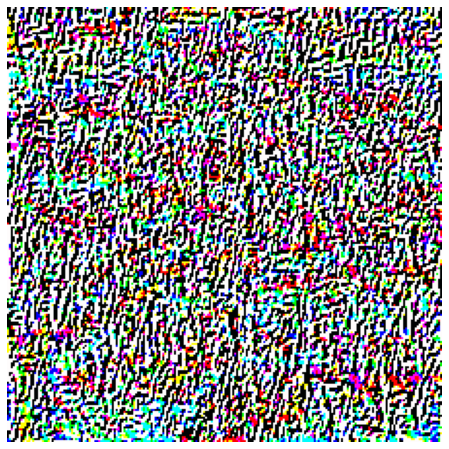

In [48]:
norms(image, image_pgd_2)

#### BasicIterativeMethod

In [49]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

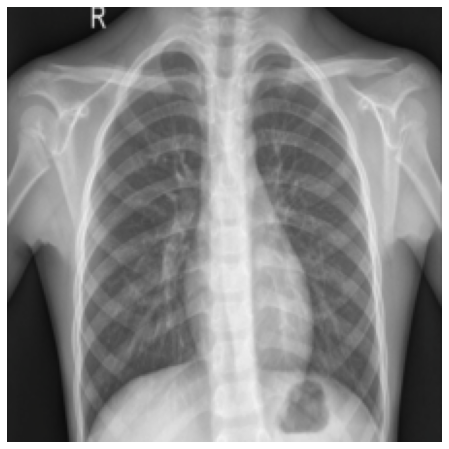

0.00041525377

In [50]:
image, label = dataset[original_image_id]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

target_image = image.cpu()
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

In [51]:
def bim(eps=0.3, max_iter=100):
    # Create the attacker:
    adv = BasicIterativeMethod(art_classifier, eps = eps, eps_step = 0.1, max_iter = max_iter, targeted = True)

    # Generate the adversarial sample:
    # x_art_adv = adv.generate(image.cpu(), y=to_categorical([1], nb_classes=2))
    x_art_adv = adv.generate(image.cpu().numpy(), y=to_categorical([1], nb_classes=2))

    # Plot the adversarial sample (note: we swap color channels back to RGB order):
    img_to_show = inv_normalize(torch.tensor(x_art_adv[0])).numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

    # And apply the classifier to it:
    pred_adv = art_classifier.predict(x_art_adv)
    print(pred_adv[0][1])
    return x_art_adv, pred_adv[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


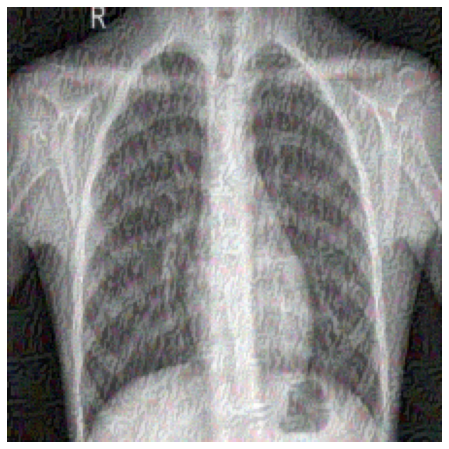

0.9999062


In [52]:
image_bim_1, _ = bim()

Perturbation l_0 norm: 87%
Perturbation l_1 norm: 8%
Perturbation l_2 norm: 9%
Noise l_inf norm: 7%


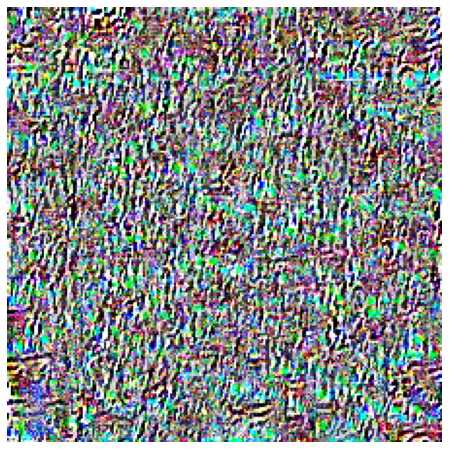

In [53]:
norms(image, image_bim_1)

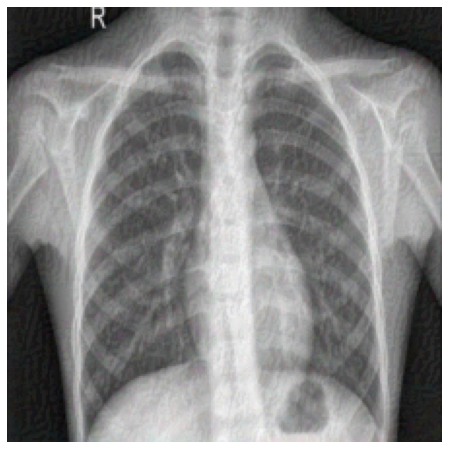

0.9997162


In [54]:
image_bim_2, _ = bim(eps=0.1)

Perturbation l_0 norm: 67%
Perturbation l_1 norm: 3%
Perturbation l_2 norm: 4%
Noise l_inf norm: 3%


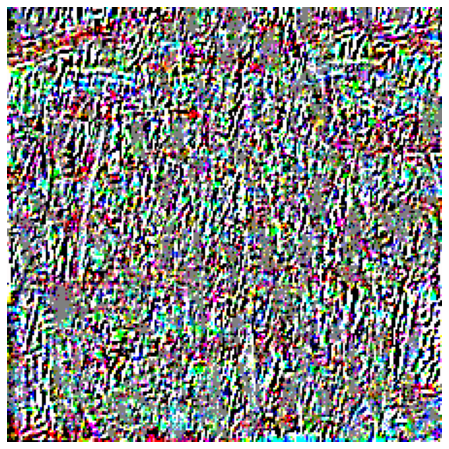

In [55]:
norms(image, image_bim_2)

#### ElasticNet

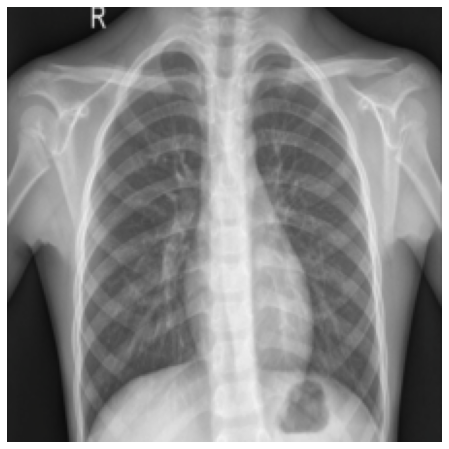

0.00041525377

In [56]:
image, label = dataset[original_image_id]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

In [57]:
def en(max_iter=100, beta=0.01):
    # Create the attacker:
    adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= max_iter, 
                     beta = beta,)
    # Generate the adversarial sample:
    # x_art_adv = adv.generate(image.cpu(), y=to_categorical([1], nb_classes=2))
    x_art_adv = adv.generate(image.cpu().numpy(), y=to_categorical([1], nb_classes=2))

    # Plot the adversarial sample (note: we swap color channels back to RGB order):
    img_to_show = inv_normalize(torch.tensor(x_art_adv[0])).numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

    # And apply the classifier to it:
    pred_adv = art_classifier.predict(x_art_adv)
    print(pred_adv[0][1])
    return x_art_adv, pred_adv[0][1]

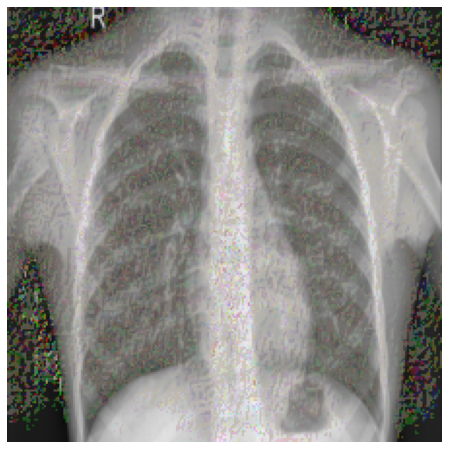

0.99953735


In [58]:
image_en_1, _ = en()

Perturbation l_0 norm: 65%
Perturbation l_1 norm: 8%
Perturbation l_2 norm: 13%
Noise l_inf norm: 59%


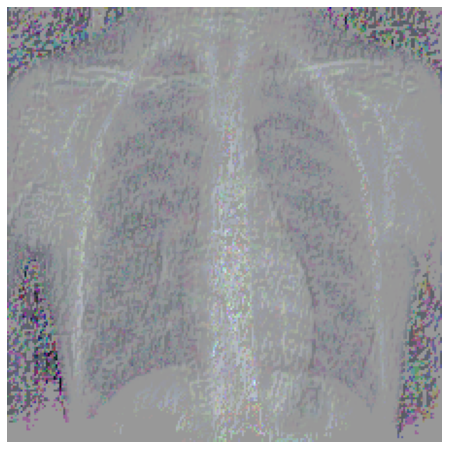

In [59]:
norms(image, image_en_1)

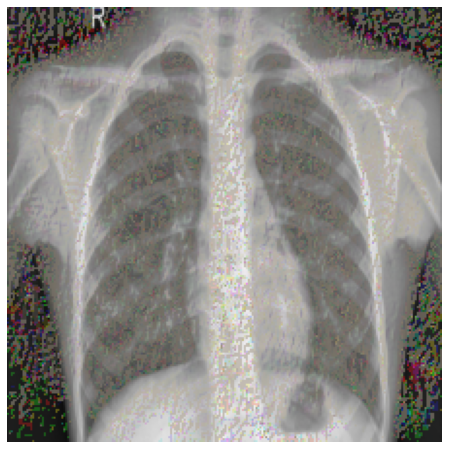

0.97670346


In [60]:
image_en_2, _ = en(max_iter=300, beta=0.001)

Perturbation l_0 norm: 76%
Perturbation l_1 norm: 8%
Perturbation l_2 norm: 14%
Noise l_inf norm: 63%


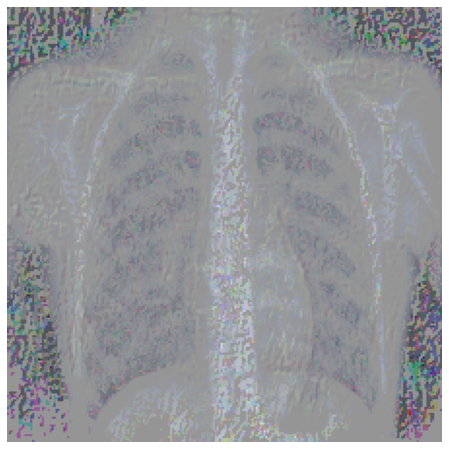

In [61]:
norms(image, image_en_2)

#### Fast Gradient Method 

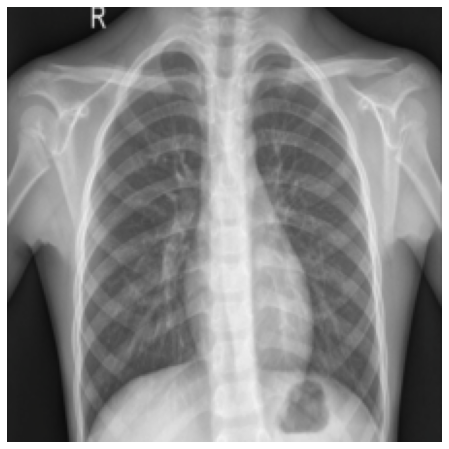

0.00041525377

In [62]:
image, label = dataset[original_image_id]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

In [63]:
def fgm(eps=0.3, norm="inf"):
    # Create the attacker:
    adv = FastGradientMethod(
        art_classifier,
        norm = norm, 
        eps = eps, 
        eps_step = 0.1, 
        targeted = True
    )
    # Generate the adversarial sample:
    # x_art_adv = adv.generate(image.cpu(), y=to_categorical([1], nb_classes=2))
    x_art_adv = adv.generate(image.cpu().numpy(), y=to_categorical([1], nb_classes=2))

    # Plot the adversarial sample (note: we swap color channels back to RGB order):
    img_to_show = inv_normalize(torch.tensor(x_art_adv[0])).numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

    # And apply the classifier to it:
    pred_adv = art_classifier.predict(x_art_adv)
    print(pred_adv[0][1])
    return x_art_adv, pred_adv[0][1]

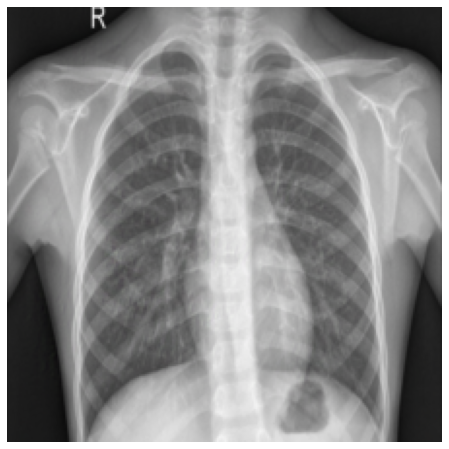

0.8685049


In [64]:
image_fgm_1, _ = fgm(eps=1000, norm=1)

Perturbation l_0 norm: 23%
Perturbation l_1 norm: 1%
Perturbation l_2 norm: 1%
Noise l_inf norm: 5%


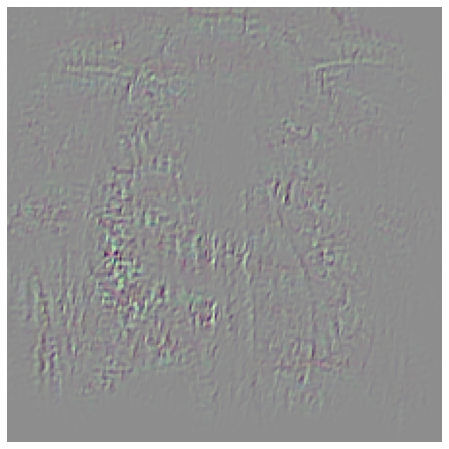

In [65]:
norms(image, image_fgm_1)

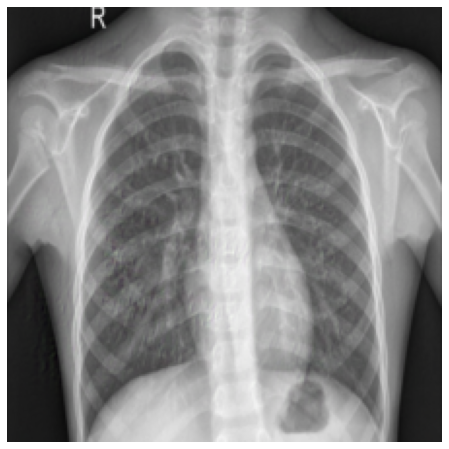

0.9864096


In [66]:
image_fgm_2, _ = fgm(eps=10, norm=2)

Perturbation l_0 norm: 42%
Perturbation l_1 norm: 1%
Perturbation l_2 norm: 2%
Noise l_inf norm: 11%


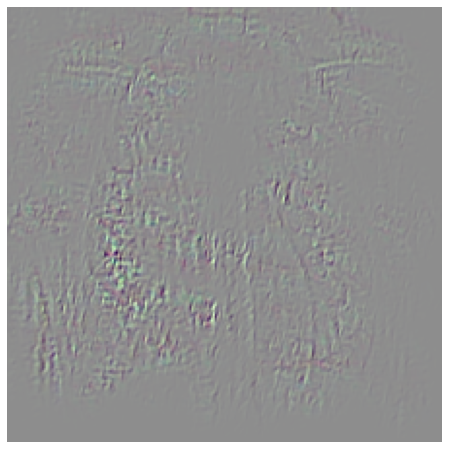

In [67]:
norms(image, image_fgm_2)